In [1]:
import pandas as pd
import numpy as np
df_train = pd.read_csv("./train.csv")
df_test = pd.read_csv("./test.csv")
df_test.loc[:, "target"] = -1
df_whole = pd.concat([df_train, df_test], ignore_index=True)
print(df_train.shape)
features = [f for f in df_train.columns if f not in ["id", "target"]]
cat_features = [f for f in features if f.startswith("cat") == True]
cont_features = [f for f in features if f.startswith("cat") == False]
print(features, cat_features, cont_features, len(features))

test_ids = df_test.loc[:,"id"]

(300000, 32)
['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18', 'cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10'] ['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18'] ['cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10'] 30


In [2]:
from sklearn import preprocessing

for f in df_whole.columns:
    if f.startswith("cat"):
        le = preprocessing.LabelEncoder()
        df_whole.loc[:, f] = le.fit_transform(df_whole.loc[:, f])
        
print(df_whole[features[2]])

# df_whole.loc[:, cat_features] = df_whole.loc[:, cat_features].astype('category')      
# print(df_whole[features[2]])

0         0
1         0
2         0
3         0
4         6
         ..
499995    0
499996    0
499997    3
499998    0
499999    0
Name: cat2, Length: 500000, dtype: int64


In [3]:
df_train = df_whole.loc[df_whole.loc[:, "target"] != -1, :]
df_test = df_whole.loc[df_whole.loc[:, "target"] == -1, :]
print(df_train.shape, df_test.shape)

(300000, 32) (200000, 32)


In [4]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
def auc_train_test(model, X, y, early_stopping_rounds=None):
    X_train, X_val, y_train, y_val = train_test_split(X , y, test_size = 0.028059109276941666 , random_state = 42)
    if early_stopping_rounds == None: 
        model.fit(X_train, y_train)
    else:
        model.fit(x_train, y_train,
              eval_set=(X_val, y_val),
              early_stopping_rounds=early_stopping_rounds,
              verbose=200)
    preds = model.predict_proba(X_val)[:, 1]
    return metrics.roc_auc_score(y_val, preds)

In [5]:
x_train, x_test, y_train = df_train.loc[:, features], df_test.loc[:, features], df_train.loc[:, "target"]

In [6]:
from category_encoders import TargetEncoder

def encode(enc, x_train, y_train, x_test):
    x_train_transformed = enc.fit_transform(x_train, y_train)
    x_test_transformed = enc.transform(x_test)
    return x_train_transformed, x_test_transformed

te = TargetEncoder(cols=cat_features)
x1, x2 = encode(te, x_train.loc[:, cat_features], y_train, x_test.loc[:, cat_features])
print(x1.shape, x2.shape)

x_train = x_train.join(x1, lsuffix="", rsuffix="_enc")
x_test = x_test.join(x2, lsuffix="", rsuffix="_enc")
print(x_train.shape, x_test.shape) 

/root/miniconda3/envs/TPS-MAR/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


(300000, 19) (200000, 19)
(300000, 49) (200000, 49)


In [42]:
from sklearn.feature_selection import chi2, f_classif, SelectKBest, SelectPercentile

# ff = x_train.columns
ff = [f for f in x_train.columns if "cat" in f]
print(ff, len(ff))
selection = SelectPercentile(chi2, percentile=10)
transformed = selection.fit_transform(x_train[ff], y_train)
print([ff[f] for f in selection.get_support(True)])
# x_train

['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18', 'cat0_enc', 'cat1_enc', 'cat2_enc', 'cat3_enc', 'cat4_enc', 'cat5_enc', 'cat6_enc', 'cat7_enc', 'cat8_enc', 'cat9_enc', 'cat10_enc', 'cat11_enc', 'cat12_enc', 'cat13_enc', 'cat14_enc', 'cat15_enc', 'cat16_enc', 'cat17_enc', 'cat18_enc'] 38
['cat2', 'cat6', 'cat7', 'cat15']


In [8]:
from lightgbm import LGBMClassifier
params = {'reg_alpha': 1.006844300332492e-05,
 'reg_lambda': 7.243837361169281,
 'num_leaves': 272,
 'learning_rate': 0.022568726939320882,
 'max_depth': 18,
 'n_estimators': 1014,
 'min_child_samples': 28,
 'min_child_weight': 4.106400865881504e-05,
 'subsample': 0.06213580871719173,
 'colsample_bytree': 0.29002277600651327,
 'cat_smooth': 47.06185805324633}
clf = LGBMClassifier(**params, n_jobs=-1)
ff = [f for f in x_train.columns if "cat" in f]
print(auc_train_test(clf, x_train.loc[:,ff], y_train))
#  all + target encoding : 0.8986121567167421

0.8907020930251678


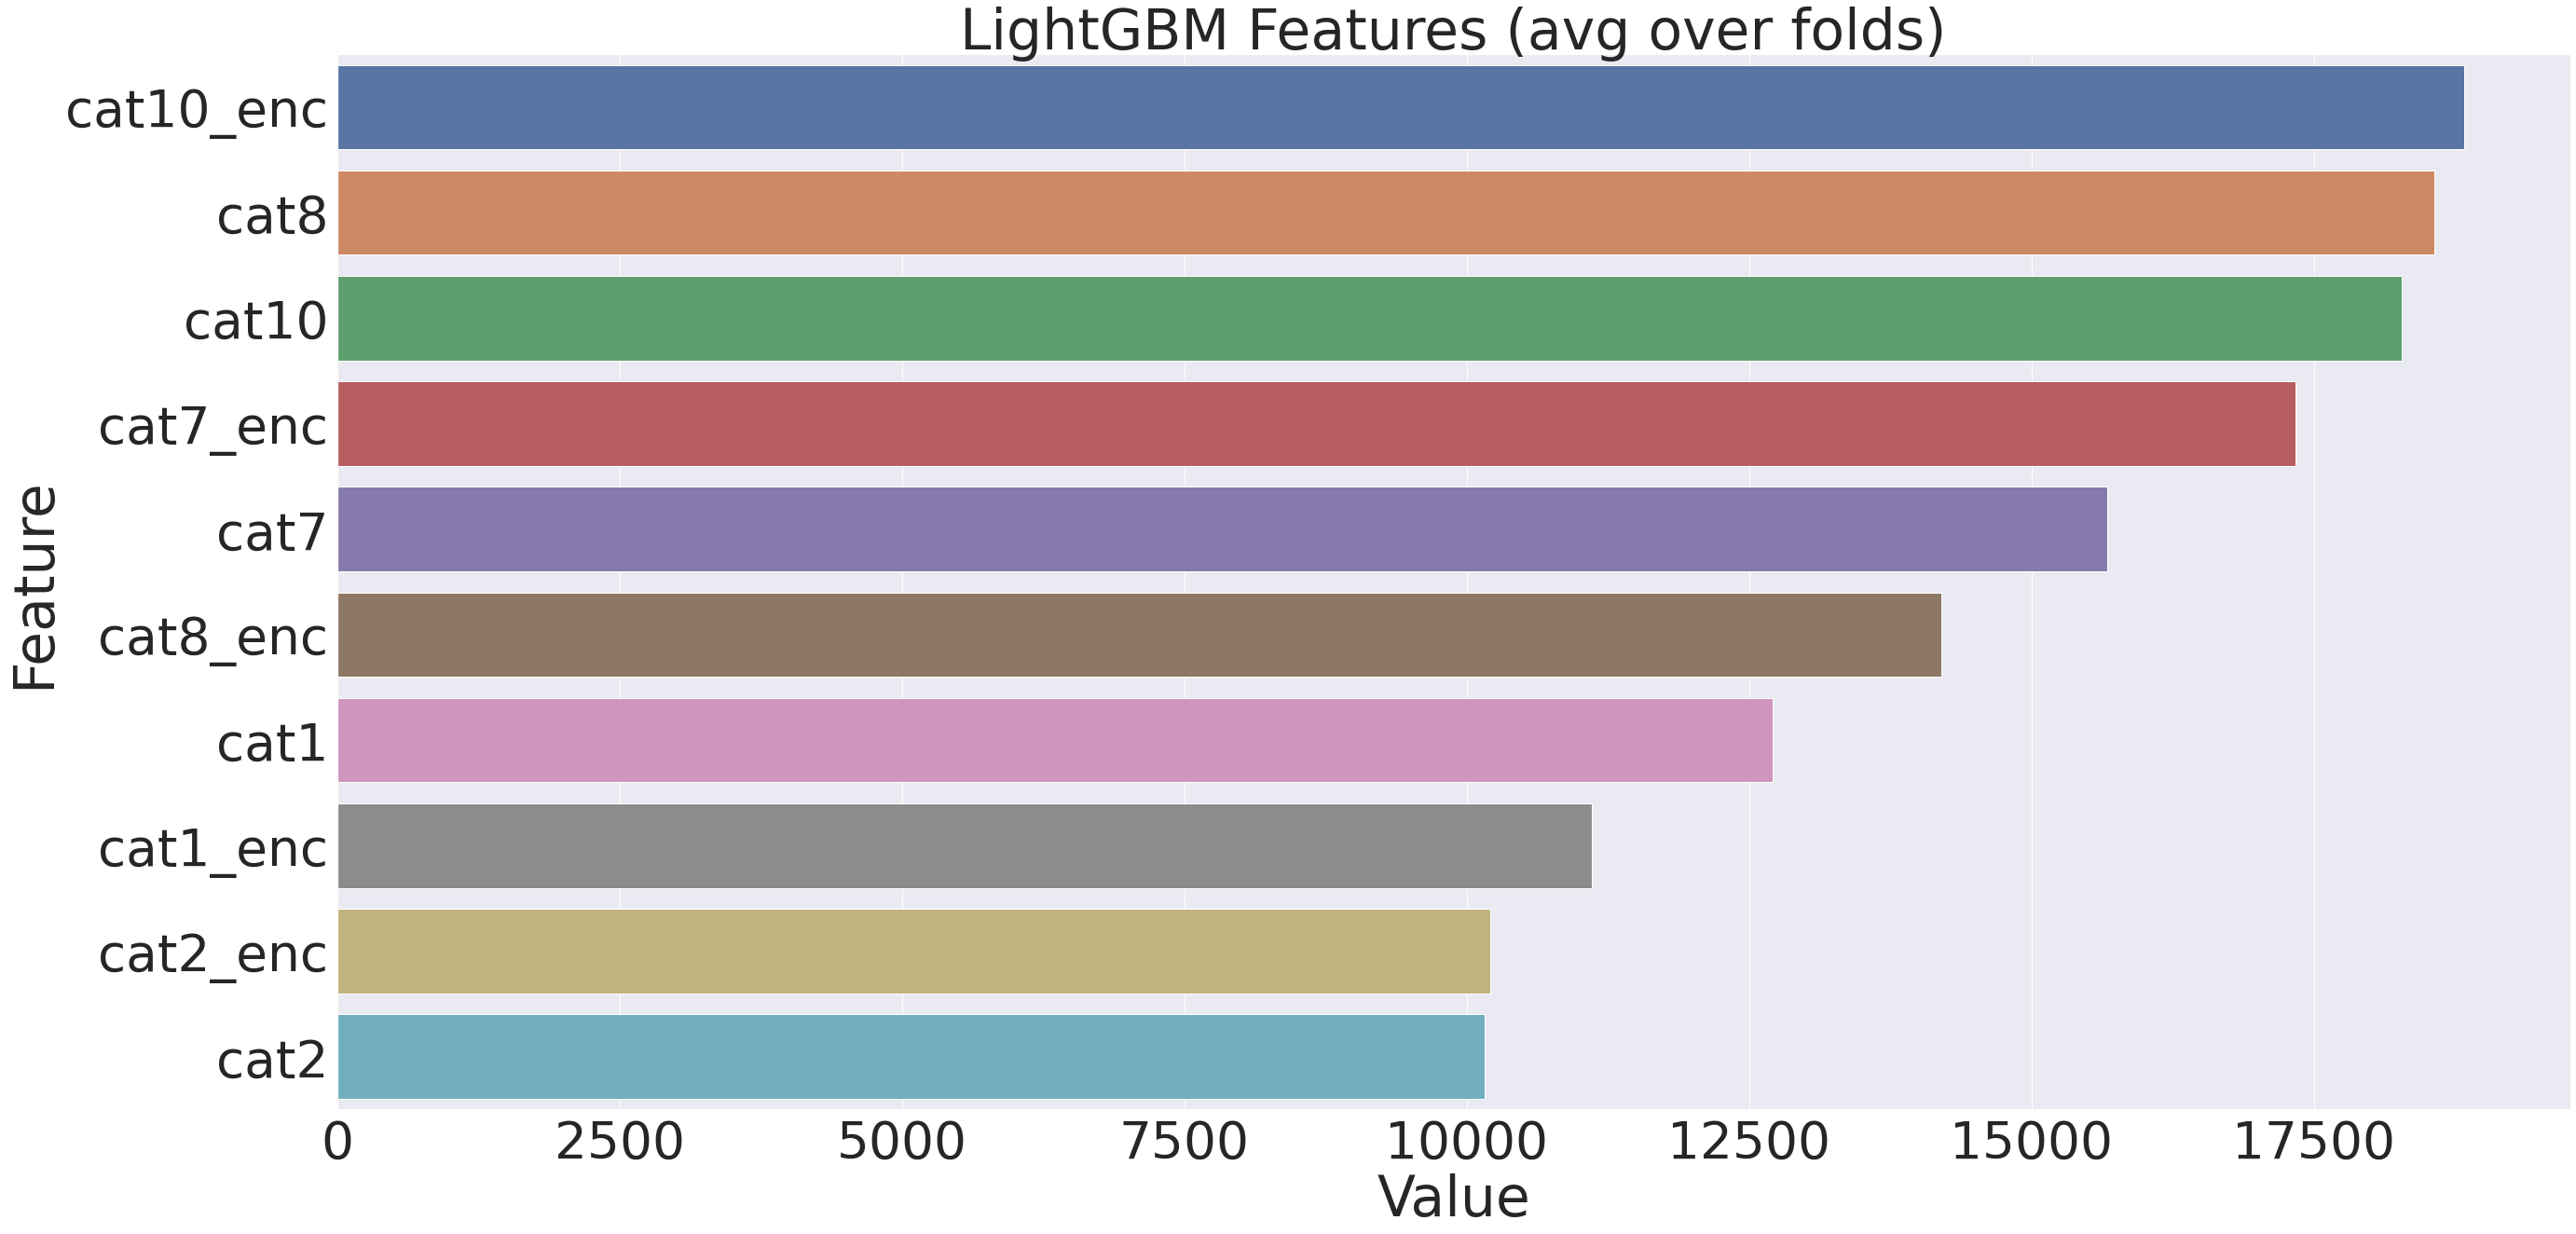

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns
feature_imp = pd.DataFrame({'Value':clf.feature_importances_,'Feature':x_train.loc[:, ff].columns})
plt.figure(figsize=(40, 20))
sns.set(font_scale = 5)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:10])
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()